<a href="https://colab.research.google.com/github/dude123studios/AdvancedDeepLearning/blob/main/Sparse_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
epochs = 20
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
train_data = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [4]:
class Encoder(K.layers.Layer):
  def __init__(self, num_units):
    super(Encoder, self).__init__(num_units)
    self.dense = K.layers.Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))
  def call(self, x):
    x = self.dense(x)
    return x

In [5]:
class Decoder(K.layers.Layer):
  def __init__(self, num_units):
    super(Decoder, self).__init__(num_units)
    self.dense = K.layers.Dense(num_units, activation='relu')
  def call(self, x):
    x = self.dense(x)
    return x

In [6]:
class Autoencoder(K.Model):
  def __init__(self, hidden_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.loss = []
    self.encoder = Encoder(hidden_dim)
    self.decoder = Decoder(original_dim)

  def call(self, input_features):
    encoded = self.encoder(input_features)
    reconstructed = self.decoder(encoded)
    return reconstructed

In [7]:
autoencoder = Autoencoder(hidden_dim, original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(real, preds)))

In [8]:
@tf.function
def train_step(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    error = loss(preds, original)
    gradients = tape.gradient(error, model.trainable_variables)
    vars = zip(gradients, model.trainable_variables)
  opt.apply_gradients(vars)
  return error

In [9]:
def train(model, opt, loss, dataset, epochs=20):
  for epoch in range(1, epochs+1):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_val = train_step(loss, model, opt, batch_features)
      epoch_loss += loss_val
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch, epochs, epoch_loss.numpy()))

In [10]:
train(autoencoder, opt, loss, train_data, epochs = epochs)

Epoch 1/20. Loss: 5.149855136871338
Epoch 2/20. Loss: 3.075308084487915
Epoch 3/20. Loss: 2.9601845741271973
Epoch 4/20. Loss: 2.9237735271453857
Epoch 5/20. Loss: 2.8884551525115967
Epoch 6/20. Loss: 2.846160650253296
Epoch 7/20. Loss: 2.861264705657959
Epoch 8/20. Loss: 2.8490428924560547
Epoch 9/20. Loss: 2.862525701522827
Epoch 10/20. Loss: 2.835775375366211
Epoch 11/20. Loss: 2.8483784198760986
Epoch 12/20. Loss: 2.8167901039123535
Epoch 13/20. Loss: 2.828310012817383
Epoch 14/20. Loss: 2.8239779472351074
Epoch 15/20. Loss: 2.824647903442383
Epoch 16/20. Loss: 2.825921058654785
Epoch 17/20. Loss: 2.8310515880584717
Epoch 18/20. Loss: 2.8005411624908447
Epoch 19/20. Loss: 2.8304150104522705
Epoch 20/20. Loss: 2.827460289001465


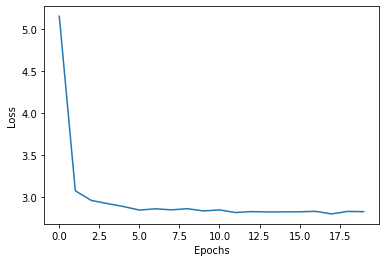

In [11]:
plt.plot(range(epochs), autoencoder.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

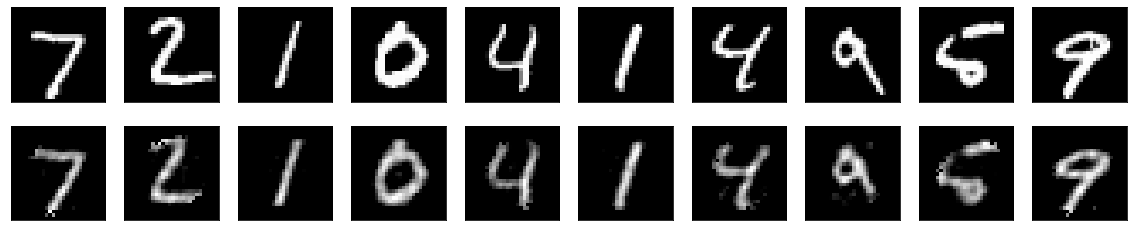

In [12]:
number = 10  
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()